# 1 Import Statements

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches as patch

# 2 Constants

In [2]:
###############################################################################
n_param = 4

# 3 Functions

## 3a Model and its Partial Derivatives

In [3]:
def mu(z, a, b, c, d):
    return a**3*b**2*z**2 + b*c**4*d**3*z + a*c*d*z/b**3 + np.exp(a*z) + a*c*np.sin(d)

In [4]:
def mu_a(z, a, b, c, d):
    return 3*a**2*b**2*z**2 + c*d*z/b**3 + 2*np.exp(a*z) + c*np.sin(d)

def mu_b(z, a, b, c, d):
    return 2*a**3*b**2*z**2 + c**4*d**3*z - 3*a*c*d*z/b**4

def mu_c(z, a, b, c, d):
    return 4*b*c**3*d**3*z + a*d*z/b**3 + a*np.sin(d)

def mu_d(z, a, b, c, d):
    return 3*b*c**4*d**2*z + a*c*z/b**3 + a*c*np.cos(d)

In [5]:
def mu_aa(z, a, b, c, d):
    return 6*a*b**2*z**2 + z**2*np.exp(a*z)

def mu_ab(z, a, b, c, d):
    return 6*a**2*b*z**2 - 3*c*d*z/b**4

def mu_ac(z, a, b, c, d):
    return d*z/b**3 + np.sin(d)

def mu_ad(z, a, b, c, d):
    return c*z/b**3 + c*np.cos(d)

def mu_bb(z, a, b, c, d):
    return 4*a**3*b*z**2 + 12*a*c*d*z/b**5

def mu_bc(z, a, b, c, d):
    return 4*c**3*d**3*z - 3*a*d*z/b**4

def mu_bd(z, a, b, c, d):
    return 3*c**4*d**2*z - 3*a*c*z/b**4

def mu_cc(z, a, b, c, d):
    return 12*b*c**2*d**3*z

def mu_cd(z, a, b, c, d):
    return 12*b*c**3*d**2*z + a*z/b**3 + a*np.cos(d)

def mu_dd(z, a, b, c, d):
    return 6*b*c**4*d*z - a*c*np.sin(d)

In [6]:
def mu_operator(z, a, b, c, d, i=-1, j=-1):
    '''
        where 0,1,2,3 correspond to a,b,c,d respectively
    '''
    mu_dir = [mu,
              [mu_a, mu_b, mu_c, mu_d],
              [[mu_aa, mu_ab, mu_ac, mu_ad],
               [mu_ab, mu_bb, mu_bc, mu_bd],
               [mu_ac, mu_bc, mu_cc, mu_cd],
               [mu_ad, mu_bd, mu_cd, mu_dd]]]
    if i >= 0:
        if j >= 0:
            return mu_dir[2][i][j](z, a, b, c, d)
        else:
            return mu_dir[1][i](z, a, b, c, d)
    else:
        return mu_dir[0](z, a, b, c, d)

## 3b Multivariate Gaussians

In [7]:
def g(a, b, a0, b0, F):
    norm = 1/(2*np.pi*np.sqrt(np.linalg.det(F)))
    M = np.linalg.inv(F)
    curve = np.zeros((len(a), len(b), 3))
    for i, alpha in enumerate(a - a0):
        for j, beta in enumerate(b - b0):
            curve[j,i] = np.array([alpha, beta, 
                                   np.exp(-1/2 * (M[0,0]*(alpha)**2 
                                                  + (M[0,1] + M[1,0])*(alpha)*(beta) 
                                                  + M[1,1]*(beta)**2))])
    return norm * curve

In [8]:
def g_a(a, b, a0, b0, S):
    gaussian = g(a, b, a0, b0, S)
    S_inv = np.linalg.inv(S)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(a-a0) + (S_inv[1,0] + S_inv[0,1])*(b-b0))
    return gaussian[:,:,2] * (left - right)

In [9]:
def g_b(a, b, a0, b0, S):
    gaussian = g(a, b, a0, b0, S)
    S_inv = np.linalg.inv(S)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(b-b0) + (S_inv[1,0] + S_inv[0,1])*(a-a0))
    return gaussian[:,:,2] * (left - right)

In [10]:
def confidence(C, ax, mean=[0,0], sf=0.5):
    x_var = np.sqrt((C[0,0] + C[1,1])/2 + np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    y_var = np.sqrt((C[0,0] + C[1,1])/2 - np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    alpha = [1.52, 2.48, 3.44]
    theta = (np.arctan((2*C[0,1])/(C[0,0] - C[1,1])))/2 * 180/np.pi
    colors = ['black', 'gray', 'pink']
    labels = ['$1\sigma$', '$2\sigma$', '$3\sigma$']
    for i in range(len(alpha)):
        ax.add_patch(patch.Ellipse(mean, alpha[i]*sf*x_var, alpha[i]*sf*y_var, 
                                   angle=theta, facecolor='none', 
                                   edgecolor=colors[i], label=labels[i], 
                                   linewidth=1.5))
    return x_var, y_var, alpha, theta

def plot_confidence(C, a0, b0, figsize=6, xlim=0.1, ylim=0.1, 
                    figname='avb.png', sf=0.5):
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    x_var, y_var, alpha, theta = confidence(C, ax, mean=(a0,b0), sf=sf)
    ax.set_xlim((a0-xlim,a0+xlim))
    ax.set_ylim((b0-ylim,b0+ylim))
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.legend()
    plt.title('a vs b Probability Space', size=16)

## 3c Derivative Tensors

Including the Fisher matrix, its derivative-analogue the Flexion, and its 2nd-derivative the Quarxion.

In [11]:
def F(z, p0, M, n=n_param):
    FISH = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            FISH[i,j] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i)).T, M), 
                                  mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
    return FISH

In [12]:
def S(z, p0, M, n=n_param):
    FLEX = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                FLEX[i,j,k] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j)).T, M), 
                                        mu_operator(z, p0[0], p0[1], p0[2], p0[3], k))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k)).T, M), 
                                         mu_operator(     z, p0[0], p0[1], p0[2], p0[3], j))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k)).T, M), 
                                         mu_operator(z, p0[0], p0[1], p0[2], p0[3], i))
    return FLEX

In [13]:
def dice(A, i, j, k=-1):
    if k >= 0:
        return np.array([[A[i,i,k], A[i,j,k]], [A[j,i,k], A[j,j,k]]])
    else:
        return np.array([[A[i,i], A[i,j]], [A[j,i], A[j,j]]])

# 4 Assignments

In [14]:
res = 10**3

l = np.array([-2,0,-2,0])
r = np.array([6,8,6,8])

a = np.linspace(l[0],r[0],res)
b = np.linspace(l[1],r[1],res)
c = np.linspace(l[2],r[2],res)
d = np.linspace(l[3],r[3],res)

a0 = 2
b0 = 4
c0 = 3
d0 = 3

In [15]:
p = np.array([a,b,c,d])
p0 = np.array([a0,b0,c0,d0])

In [264]:
C = np.random.randint(1000,size=(7,7))
C = (C+C.T)/2
M = np.linalg.inv(C)

z = np.linspace(0.1,1,C.shape[0])

# 5 Workspace

## 5a Plotting first order

In [266]:
fisher = F(z, p0, M)
flexion = S(z, p0, M)

In [268]:
diced_fish = dice(fisher,0,1)
fisher_inv = np.linalg.inv(diced_fish)

In [270]:
foo = g(a, b, a0, b0, fisher)[:,:,2]
foo /= np.sum(foo)

In [275]:
foo_a = g_a(a, b, a0, b0, dice(flexion,0,1,0))
print(foo_a.shape)

/Users/hansen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(1000, 1000)


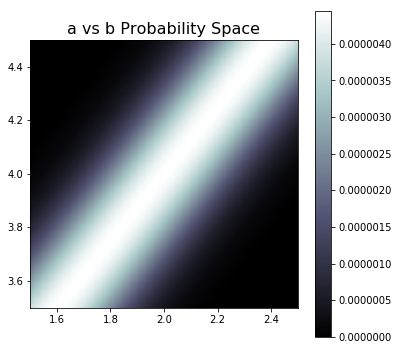

In [272]:
plt.figure(figsize=(6,6))
#plot_confidence(C, a0, b0, xlim=1, ylim=1, sf=0.3989)
plt.imshow(foo2, cmap='bone', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
plt.colorbar()
plt.title('a vs b Probability Space', size=16)
plt.xlim((1.5,2.5))
plt.ylim((3.5,4.5))
plt.show()
plt.cla()
plt.clf()
plt.close()

## 5b Finding Contour Levels

In [21]:
goo = g(a, b, a0, b0, C)[:,:,2]
norm = np.sum(goo)
goo2 = goo/norm
print(np.max(goo2))

2.0831848887412357e-05


In [252]:
def find_levels(g, ratios=np.array([0.6826/1.75, 0.9546/1.75, 0.9973/1.75]), res=10**3, delta=10**-3):
    ''' Finds the levels corresponding to the first three standard deviations.
        Returns:
            
    '''
    levels = []
    for sigma in ratios:
        for level in np.power(10,np.linspace(np.log10(np.max(g)), np.log10(np.min(g)), res)):
            ratio = len(np.where(g>=level)[0])/len(g)**2
            if ((ratio >= sigma-delta) and (ratio <= sigma+delta)):
                levels.append(level)
                break
    return np.flip(levels)

In [253]:
%%time
levels = find_levels(goo)

CPU times: user 6.63 s, sys: 1.62 s, total: 8.25 s
Wall time: 8.25 s


In [256]:
levels

array([1.43950892e-06, 2.91178202e-06, 9.48166122e-05])

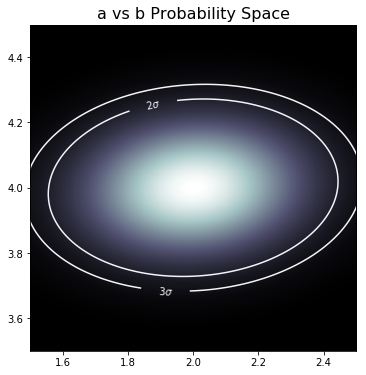

In [260]:
xlim=1
ylim=1
#levels=[1.929122819209519*10**-16, 1.8787527816914209*10**-13, 3.6844287154608366*10**-8]
#levels=[10**-6, 4*10**-6, 10**-5]
plt.figure(figsize=(6,6))
#plot_confidence(C, a0, b0, xlim=1, ylim=1, sf=0.3989)
plt.imshow(goo2, cmap='bone', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
#plt.colorbar()
cs = plt.contour(goo2, extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], cmap='PuRd',
                 levels=levels)
plt.clabel(cs, fmt={levels[0]:'3$\sigma$', levels[1]:'2$\sigma$', levels[2]:'1$\sigma$'})
plt.title('a vs b Probability Space', size=16)
plt.xlim((1.5,2.5))
plt.ylim((3.5,4.5))
plt.show()
plt.cla()
plt.clf()
plt.close()

In [243]:
print(cs)

## 5c Plotting Second Order

In [ ]:
xlim=1
ylim=1
plot_confidence(C, a0, b0, xlim=1, ylim=1)
plt.imshow(g(a, b, a0, b0, C)[:,:,2], cmap='YlOrRd', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
plt.contour(g(a, b, a0, b0, C)[:,:,2], extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], cmap='PuRd')
plt.title('a vs b Probability Space', size=16)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [ ]:
gaussian = g(a, b, a0, b0, dice(fisher,0,1))
gaussian[:,:,2].shape

In [ ]:
F_inv = np.linalg.inv(dice(fisher,0,1))
plt.imshow(g(a,b,a0,b0,F_inv)[:,:,2])

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(gaussian[:,:,2], cmap='gray', 
           extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))
plt.xlabel('b')
plt.ylabel('a')
plt.title('b v a parameter space')
plt.colorbar()

In [ ]:
gaussian_a = g_a(a, b, a0, b0, dice(flexion,0,1,2))
gaussian_b = g_b(a, b, a0, b0, dice(flexion,0,1,0))

In [ ]:
print(np.max(gaussian_a), np.max(gaussian_b), np.max(gaussian))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,0)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,1)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,2)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,3)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(gaussian[:,:,2], extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))
plt.contour(gaussian[:,:,2], extent=[l[1],r[1],l[0],r[0]])

In [ ]:
# Mapping the function on b v c
function = np.zeros((res, res))
for i, alpha in enumerate(b):
    for j, beta in enumerate(c):
        function[i,j] = mu(1, alpha, beta, c0, d0)

plt.figure(figsize=(8,8))
plt.imshow(function, cmap='gray', #norm=LogNorm(vmin=10**-10, vmax=10**-0.5),
           extent=[l[1],r[1],l[2],r[2]], aspect=(r[1]-l[1])/(r[2]-l[2]))
plt.colorbar()

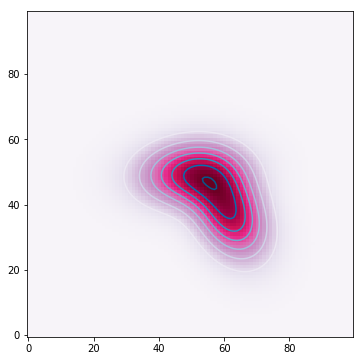

In [157]:
C2 = np.array([[0.2,-0.3],[0.15,0.3]])
goob = g(c, d, c0, d0, C2)[:,:,2]
goob /= np.sum(goob)

plt.figure(figsize=(6,6))
plt.imshow(goob+goo2, cmap='PuRd', origin='lower')
plt.contour(goob+goo2, cmap='PuBu')